## Setup

Install the Python SDK.

In [1]:
from kaggle_secrets import UserSecretsClient

In [2]:
import requests
import os
import csv
import time

ADS_API_TOKEN = UserSecretsClient().get_secret("ADS_API_TOKEN")  # Retrieve the API token from the environment variable
OBJECT_NAME = "V808 Aur"  # Replace with your file name
DOWNLOAD_DIR = "resuming_table"  # Directory to save PDFs

if not os.path.exists(DOWNLOAD_DIR):
    os.makedirs(DOWNLOAD_DIR)  # Create the directory if it doesn't exist
    print(f"Directory '{DOWNLOAD_DIR}' created.")
else:
    print(f"Directory '{DOWNLOAD_DIR}' already exists.")

Directory 'resuming_table' created.


Next fuction ***query_ads_api_by_bibcode*** searches a paper by a bibcode, it was made for tests.

In [3]:
def query_ads_api_by_bibcode(bibcode):
    headers = {"Authorization": f"Bearer {ADS_API_TOKEN}"}
    # Query directly for the bibcode
    query = f"bibcode:{bibcode}"
    # Request all fields for detailed inspection
    params = {"q": query, "fl": "*"}

    try:
        response = requests.get("https://api.adsabs.harvard.edu/v1/search/query", headers=headers, params=params)
        time.sleep(1)  # Add a 1-second delay to avoid overloading the server

        if response.status_code == 200:
            api_response = response.json()

            # Print the entire response to inspect its structure
            print("Full API Response:")
            print(json.dumps(api_response, indent=4))  # Use json.dumps for pretty printing

            return api_response
        else:
            print(f"Error: ADS API request failed with status code {response.status_code}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Error: Failed to query ADS API: {e}")
        return None

Function ***query_ads_api_by_name*** searches all papers for an object and choses only neccesary fields mentioned in ***params:fl***

In [4]:
import requests
from urllib.parse import urlencode

def search_by_object_name(object_name, token):
    """
    Searches the ADS API for records related to a given object name,
    filtered to the astronomy database, and returns bibcode, database, and property.
    """

    encoded_query = urlencode({
        "q": f"full:{object_name}",  # Search for the object name in all metadata fields
        "fq": "database:astronomy",  # Filter to the astronomy database
        "fl": "bibcode,abstract,database,property",  # Return bibcode, database, and property fields
        "rows": 2000  # Maximum number of rows to return (adjust as needed)
    })

    results = requests.get(
        f"https://api.adsabs.harvard.edu/v1/search/query?{encoded_query}",
        headers={'Authorization': 'Bearer ' + token}
    )

    return results.json()


# Example usage: Replace with the object name you want to search for
api_response = search_by_object_name(OBJECT_NAME, ADS_API_TOKEN)

In [5]:
!pip install -Uq "google-genai==1.7.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 5.1 MB/s eta 0:00:00


In [6]:
from google import genai
from google.genai import types

from IPython.display import Markdown, display

genai.__version__

'1.7.0'

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [7]:
from kaggle_secrets import UserSecretsClient

client = genai.Client(api_key=UserSecretsClient().get_secret("GOOGLE_API_KEY"))

If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)

### Automated retry

This codelab sends a lot of requests, so set up an automatic retry
that ensures your requests are retried when per-minute quota is reached.

In [8]:
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

In [9]:
import re 

def analyze_abstract(abstract_text, object_name):
    """
    Analyzes an abstract using the Gemini model to extract information about
    orbital period, masses, inclination, magnetic field, and accretion/brightness states.
    Returns a specific message if no information is found.
    """

    prompt = f"""
    You are an expert astronomer analyzing a research paper abstract about {object_name}.
    Your task is to identify if the abstract mentions the following parameters and their values.
    If a parameter is not mentioned, you MUST return the corresponding JSON structure with "is": false.

    - Orbital Period (P_orb): Report the value and units (days, years, etc.).
    - Mass of primary component (M1): Report the value and units (solar masses).
    - Mass of secondary component (M2): Report the value and units (solar masses).
    - Inclination Angle (i): Report the value and units (degrees).
    - Magnetic Field Strength (B): Report the value and units (Gauss, Tesla, etc.). If multiple magnetic poles are mentioned, include "multipole": true and report the field strength for each pole (e.g., B1, B2).
    - Accretion or Brightness States (States): Report the energy range (X-ray, optical, IR, etc.) and whether magnitude or flux variations are mentioned, along with their units (if applicable).

    Follow this JSON template:
    {{
        "P_orb": {{"is": false}},
        "M1": {{"is": false}},
        "M2": {{"is": false}},
        "i": {{"is": false}},
        "B": {{"is": false}},
        "States": {{"is": false}}
    }}

    If the abstract does not contain any information about the object {object_name},
    return the following JSON:
    {{
        "No information found": "True"
    }}

    Abstract:
    {abstract_text}

    Output in JSON format:
    """

    try:
        # Set the temperature low to stabilize the output.
        config = types.GenerateContentConfig(temperature=0.1)

        response = client.models.generate_content(
        model='gemini-2.0-flash',
        config=config,
        contents=[prompt],
        )

        json_string = response.text

        # Use a regular expression to remove any non-JSON characters from the beginning and end of the string
        json_string = re.sub(r"^[^\{]*", "", json_string)
        json_string = re.sub(r"[^\}]*$", "", json_string)

        try:
            data = json.loads(json_string)
            return data
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
            print(f"Problematic JSON string: {json_string}")
            return None

    except Exception as e:
        print(f"Error during Gemini API call: {e}")
        return None


# Searches for papers related to the object name, analyzes their abstracts, and saves the results in a JSON file.


In [10]:
import json

results = {}

if api_response and "response" in api_response and "docs" in api_response["response"]:
    for paper in api_response["response"]["docs"]:
        bibcode = paper.get("bibcode")
        abstract = paper.get("abstract")
        property_values = paper.get("property", [])

        if bibcode and abstract:
            analysis_result = analyze_abstract(abstract, OBJECT_NAME)

            if analysis_result and "No information found" not in analysis_result:
                results[bibcode] = analysis_result
                # Add openaccess information, filtering properties
                openaccess_properties = [prop for prop in property_values if "OPENACCESS" in prop.upper()]
                is_openaccess = len(openaccess_properties) > 0
    
                results[bibcode]["openaccess"] = {
                    "is": is_openaccess,
                    "properties": openaccess_properties
                }
            # Skip bibcodes with "No information found"
            elif analysis_result and "No information found" in analysis_result:
                print(f"Skipping {bibcode} due to no information found.")
            else:
                results[bibcode] = {"error": "Analysis failed"}

            
        else:
            print(f"Skipping paper due to missing bibcode or abstract.")

else:
    print("No results found.")

# Save the results to a JSON file
output_filename = f"{OBJECT_NAME.replace(' ', '_')}_results.json"
output_filename = os.path.join(DOWNLOAD_DIR, output_filename)
with open(output_filename, "w") as f:
    json.dump(results, f, indent=4)

print(f"Results saved to {output_filename}")

Skipping 2018AN....339..540S due to no information found.
Skipping 2017ASPC..510..502K due to no information found.
Results saved to resuming_table/V808_Aur_results.json


In [11]:
import pandas as pd

def results_as_table(results):
    """
    Unnests the JSON data for all objects and displays it as a table, with bibcode as a column.

    Args:
        results (dict): The nested JSON data loaded into a Python dictionary.
    """

    table_data = []
    for bibcode, object_data in results.items():
        for key, value in object_data.items():
            if isinstance(value, dict):
                if "is" in value:
                    is_value = value["is"]
                else:
                    is_value = None

                if "value" in value:
                    actual_value = value["value"]
                else:
                    actual_value = None

                if "units" in value:
                    units = value["units"]
                else:
                    units = None

                if "properties" in value:
                    properties = ", ".join(value["properties"])
                else:
                    properties = None

                table_data.append({
                    "Bibcode": bibcode,
                    "Parameter": key,
                    "Is Present": is_value,
                    "Value": actual_value,
                    "Units": units,
                    "Properties": properties
                })
            elif key == "No information found":
                table_data.append({
                    "Bibcode": bibcode,
                    "Parameter": key,
                    "Is Present": value,
                    "Value": None,
                    "Units": None,
                    "Properties": None
                })

    # Create a Pandas DataFrame from the unnested data
    df = pd.DataFrame(table_data)

    return df
    
# Example Usage (assuming you have the 'results' dictionary populated):
results_df = results_as_table(results)
# Display the DataFrame as a table
print("Search Results:")
print(results_df[results_df.Bibcode == results_df.Bibcode[7]])

Search Results:
                Bibcode   Parameter  Is Present Value      Units Properties
7   2019ARep...63..751Z       P_orb       False  None       None       None
8   2019ARep...63..751Z          M1       False  None       None       None
9   2019ARep...63..751Z          M2       False  None       None       None
10  2019ARep...63..751Z           i       False  None       None       None
11  2019ARep...63..751Z           B       False  None       None       None
12  2019ARep...63..751Z      States        True  None  magnitude       None
13  2019ARep...63..751Z  openaccess       False  None       None           


Now we want to checkout the papers that could have valuable information. For that we need to download them. 

In [12]:
def find_bibcodes_by_parameters(results, search_params):
    """
    Finds bibcodes in the results dictionary that match the specified search parameters.

    Args:
        results (dict): The dictionary containing the analyzed paper data.
        search_params (dict): A dictionary of search parameters, where keys are parameter names
                              (e.g., "openaccess", "P_orb") and values are the desired values
                              (e.g., True, False).

    Returns:
        list: A list of bibcodes that match the search parameters.
    """

    matching_bibcodes = []

    for bibcode, data in results.items():
        match = True  # Assume the bibcode matches initially

        for param, desired_value in search_params.items():
            if param in data:
                if isinstance(data[param], dict) and "is" in data[param]:
                    # Handle nested dictionaries with "is" key (e.g., P_orb, openaccess)
                    if data[param]["is"] != desired_value:
                        match = False
                        break  # No need to check other parameters for this bibcode
                elif data[param] != desired_value:
                    # Handle simple key-value pairs (e.g., "No information found": True)
                    match = False
                    break
            else:
                # Parameter not found in the data for this bibcode
                match = False
                break

        if match:
            matching_bibcodes.append(bibcode)

    return matching_bibcodes

In [13]:
chosen_papers = find_bibcodes_by_parameters(results, search_params={'openaccess': True, 'P_orb': True})

In [14]:
def download_pdfs_by_bibcodes(bibcodes, object_name, download_directory="downloaded_pdfs"):
    """
    Downloads PDFs for a list of bibcodes, creating URLs based on open access availability.

    Args:
        bibcodes (list): A list of bibcodes to download PDFs for.
        object_name (str): The name of the object being studied (used for filename).
        download_directory (str): The directory to save the downloaded PDFs.
    """

    # Create the download directory if it doesn't exist
    if not os.path.exists(download_directory):
        os.makedirs(download_directory)
        print(f"Created directory: {download_directory}")

    for bibcode in bibcodes:
        eprint_url = f"https://ui.adsabs.harvard.edu/link_gateway/{bibcode}/EPRINT_PDF"
        pub_url = f"https://ui.adsabs.harvard.edu/link_gateway/{bibcode}/PUB_PDF"
        output_filename = os.path.join(download_directory, f"{object_name.replace(' ', '_')}_{bibcode}.pdf")

        # Try downloading from arXiv first
        try:
            response = requests.get(eprint_url)
            response.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)
            with open(output_filename, 'wb') as f:
                f.write(response.content)
            print(f"Downloaded arXiv PDF: {output_filename}")
            continue  # Skip to the next bibcode after successful download
        except requests.exceptions.RequestException:
            print(f"arXiv PDF not found for {bibcode}. Trying publisher PDF...")

        # If arXiv fails, try downloading from the publisher
        try:
            response = requests.get(pub_url)
            response.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)
            with open(output_filename, 'wb') as f:
                f.write(response.content)
            print(f"Downloaded publisher PDF: {output_filename}")
        except requests.exceptions.RequestException as e:
            print(f"Error downloading PDF for {bibcode}: {e}")

# Example Usage:
# Assuming you have a list of bibcodes called 'bibcodes_to_download'
# object_name = "YourObjectName"  # Replace with your object name
# download_pdfs_by_bibcodes(bibcodes_to_download, object_name)    

In [15]:
download_pdfs_by_bibcodes(chosen_papers, OBJECT_NAME)

Created directory: downloaded_pdfs
Downloaded arXiv PDF: downloaded_pdfs/V808_Aur_2024ApJ...967...81L.pdf
arXiv PDF not found for 2020PhDT........58A. Trying publisher PDF...
Error downloading PDF for 2020PhDT........58A: 404 Client Error: NOT FOUND for url: https://ui.adsabs.harvard.edu/link_gateway/2020PhDT........58A/PUB_PDF
Downloaded arXiv PDF: downloaded_pdfs/V808_Aur_2024A&A...686A.175O.pdf
Downloaded arXiv PDF: downloaded_pdfs/V808_Aur_2018AJ....155...18L.pdf


Now we could use Generative AI to check the full papers and understand what methods were used to determine parameters.

In [16]:
import google.generativeai as genai
from google.api_core import exceptions # For specific error handling
from IPython.display import Markdown, display
import traceback
import time # For potential retries or delays

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("GOOGLE_API_KEY")

    # Configure the GenAI library
    genai.configure(api_key=api_key)
    print("Google AI SDK configured successfully.")

    # Define the model client
    # Use a model compatible with the File API, like gemini-1.5-flash or gemini-1.5-pro
    # 'gemini-1.5-flash-latest' usually points to the most recent flash model
    model = genai.GenerativeModel('gemini-2.0-flash')
    print(f"Using model: {model.model_name}")

except UserSecretsClient.SecretNotFoundError:
    print("ERROR: Secret 'GOOGLE_API_KEY' not found. Please add it via Add-ons -> Secrets.")
    # Stop execution or handle appropriately
    raise # Re-raise the error to stop the notebook cell
except Exception as e:
    print(f"ERROR during Authentication or Initialization: {e}")
    print(traceback.format_exc()) # Print detailed traceback
    # Stop execution or handle appropriately
    raise # Re-raise the error

# --- 4. Function Definitions ---

# Function to summarise document (accepts uploaded file object)
def summarise_doc(request: str, uploaded_file_object) -> str:
    """Execute the request on the provided uploaded file object."""
    # Note: Configuration can be passed directly to generate_content

    generation_config = genai.types.GenerationConfig(temperature=0.0)
    try:
        # Create the prompt and include the uploaded file object
        response = model.generate_content(
            [request, uploaded_file_object], # Pass text prompt and file object
            generation_config=generation_config
            # Optional: Add safety settings if needed
            # safety_settings=...
        )
        # Check response for issues before accessing text
        if not response.candidates or response.candidates[0].finish_reason.name not in ["STOP", "MAX_TOKENS"]:
             reason = response.candidates[0].finish_reason.name if response.candidates else "UNKNOWN"
             safety_ratings_str = str(response.candidates[0].safety_ratings) if response.candidates and response.candidates[0].safety_ratings else "N/A"
             print(f"Warning: Model response potentially incomplete or blocked. Reason: {reason}. Safety Ratings: {safety_ratings_str}")
             # Attempt to return text if possible, otherwise indicate the issue
             try:
                 return response.text
             except ValueError:
                 return f"Error: Model response issue (Reason: {reason}). No text content available. Check safety ratings/prompt."

        return response.text

    except exceptions.GoogleAPIError as e:
        # Handle specific Google API errors (like quota, resource exhausted)
        print(f"ERROR during API call: {e}")
        print(traceback.format_exc())
        # Implement retry logic here if needed (e.g., for 429 Resource Exhausted)
        # if e.code == 429:
        #    time.sleep(10) # wait and potentially retry
        return f"Error processing document via API: {e}"
    except Exception as e:
        # Handle other unexpected errors
        print(f"ERROR generating content: {e}")
        print(traceback.format_exc())
        return f"Unexpected error processing document: {e}"

# Function to iterate through papers in a directory
def make_a_summary_across_papers(directory, object_name):
    """Processes papers in a directory, summarising relevant ones using Google AI SDK."""
    if not os.path.isdir(directory):
        print(f"Error: Directory not found - {directory}")
        return

    list_of_papers = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    if not list_of_papers:
        print(f"No files found in directory: {directory}")
        return

    print(f"Found {len(list_of_papers)} files to process in '{directory}'.")

    for paper_filename in list_of_papers:
        full_path = os.path.join(directory, paper_filename)
        print(f"\n--- Processing: {paper_filename} ---")

        # Only process PDF files (add other supported types if needed by the API)
        if not paper_filename.lower().endswith(".pdf"):
            print(f"Skipping non-PDF file: {paper_filename}")
            continue

        uploaded_file = None # Initialize variable to None
        try:
            # 1. Upload the file using the genai File API
            print(f"Uploading {paper_filename}...")
            # display_name helps identify the file in Google AI Studio file manager (optional)
            uploaded_file = genai.upload_file(path=full_path, display_name=paper_filename)
            print(f"Uploaded '{uploaded_file.display_name}' as {uploaded_file.name} ({uploaded_file.size_bytes} bytes)")

            # 2. Create the request for this specific paper
            request = f"""Filename: {paper_filename}

Check if the paper is about {object_name}. If it is, tell what parameters were found and what methods were used. Summarize the key findings related to {object_name}.
If it is not about the {object_name}, clearly state that it is not about {object_name}.
Ensure the first line of your response is exactly 'Filename: {paper_filename}'."""

            # 3. Call summarise_doc, passing the uploaded file object
            summary = summarise_doc(request, uploaded_file)

            # 4. Display the result
            display(Markdown(summary))

        except FileNotFoundError:
            print(f"Error: File not found at {full_path}")
            continue # Skip to the next file
        except exceptions.GoogleAPIError as e:
            print(f"Error during file upload or processing API call for {paper_filename}: {e}")
            # Consider whether to continue or stop on API errors
            continue
        except Exception as e:
            print(f"Error processing file {paper_filename}: {e}")
            print(traceback.format_exc())
            continue # Skip to the next file

        finally:
            # 5. IMPORTANT: Delete the file from the service after use
            if uploaded_file:
                try:
                    print(f"Deleting uploaded file: {uploaded_file.name}...")
                    genai.delete_file(uploaded_file.name)
                    print("File deleted successfully.")
                except Exception as e:
                    # Log deletion error but continue processing other files
                    print(f"Warning: Failed to delete file {uploaded_file.name}: {e}")


# --- 5. Execution ---


papers_directory = 'downloaded_pdfs' # ADJUST THIS PATH

# Replace 'V808_Aur' with the object name you are interested in.
target_object = 'V808_Aur'

make_a_summary_across_papers(papers_directory, target_object)


Google AI SDK configured successfully.
Using model: models/gemini-2.0-flash
Found 3 files to process in 'downloaded_pdfs'.

--- Processing: V808_Aur_2018AJ....155...18L.pdf ---
Uploading V808_Aur_2018AJ....155...18L.pdf...
Uploaded 'V808_Aur_2018AJ....155...18L.pdf' as files/285syw3nqrkm (1534595 bytes)


Filename: V808_Aur_2018AJ....155...18L.pdf
The paper is not about V808 Aur. It is about MASTER OT J132104.04+560957.8, a polar.

Deleting uploaded file: files/285syw3nqrkm...
File deleted successfully.

--- Processing: V808_Aur_2024A&A...686A.175O.pdf ---
Uploading V808_Aur_2024A&A...686A.175O.pdf...
Uploaded 'V808_Aur_2024A&A...686A.175O.pdf' as files/v1duhe6lbu91 (1467425 bytes)


Filename: V808_Aur_2024A&A...686A.175O.pdf
The paper is not about V808 Aur. It is about the discovery of a magnetic cataclysmic variable XMM J152737.4-205305.9.

Deleting uploaded file: files/v1duhe6lbu91...
File deleted successfully.

--- Processing: V808_Aur_2024ApJ...967...81L.pdf ---
Uploading V808_Aur_2024ApJ...967...81L.pdf...
Uploaded 'V808_Aur_2024ApJ...967...81L.pdf' as files/n2nwto3jb3uc (633247 bytes)


Filename: V808_Aur_2024ApJ...967...81L.pdf
Yes, the paper is about V808 Aurigae (V808 Aur).

**Parameters Found and Methods Used:**

*   **Eclipse Timings:** The primary data analyzed were eclipse timings of V808 Aur spanning 15 years (2008-2023). Eclipse timings were obtained from multiple telescopes: TESS, Sarah L. Krizmanich Telescope (SLKT), Leibniz-Institut für Astrophysik Potsdam (AIP), MONET/North, Calar Alto, Las Cumbres Observatory (LCO), and McDonald Observatory.
*   **Photometry:** Photometric data were used to determine eclipse timings and to correlate brightness with timing variations.
*   **Timing Analysis:** The observed times of mid-eclipse were compared to an ephemeris derived by Schwope et al. (2015). O-C (Observed minus Calculated) times were calculated and analyzed.
*   **Orbital Modeling:** A third-body orbital model (Irwin 1952) was used to fit the eclipse timing variations, assuming a planet orbiting the polar. The model included parameters such as orbital period, semi-amplitude, eccentricity, longitude of periastron, and epoch of periastron passage.
*   **Statistical Analysis:** Least-squares fitting was used to determine the best-fit parameters for the orbital model. The chi-squared (x²) parameter was used to assess the goodness of fit.
*   **Mass Estimation:** The mass function and projected mass of the third body were estimated based on the orbital parameters and an assumed total mass for the system.

**Key Findings Related to V808 Aur:**

*   **Eclipse Timing Variations:** The eclipse timings of V808 Aur showed significant variations, deviating from a linear ephemeris by more than 50 seconds between 2015 and 2017.
*   **Correlation with Brightness:** A correlation was found between the brightness of V808 Aur and eclipse timing residuals, with a slope of 1.1 s/mag. This was attributed to changes in the accretion geometry and luminosity with variations in the mass transfer rate.
*   **Eccentric Planet Model:** The eclipse timing variations were well-modeled by the light-travel time variation caused by a third body in a highly eccentric orbit. The best-fit orbital period for the third body was 11 ± 1 years.
*   **Projected Mass:** The projected mass of the third body was estimated to be Msin(i) = 6.8 ± 0.7 Jupiter masses.
*   **Periastron Passage:** The next periastron passage of the planet is expected to occur in 2028.
*   **Alternative Explanations:** The authors acknowledge that other mechanisms, such as the Applegate mechanism or changes in accretion geometry, could also contribute to the eclipse timing variations, but the eccentric planet model provides an excellent fit to the data.


Deleting uploaded file: files/n2nwto3jb3uc...
File deleted successfully.


# One more application for AI is image understanding. And there is a task in astronomy of outliers detection.  

In [17]:
input_dir = '/kaggle/input/'
found_files = []

print(f"--- Checking all files recursively under '{input_dir}' ---")

# Check if the base input directory exists
if not os.path.isdir(input_dir):
    print(f"Error: Base input directory '{input_dir}' does not exist.")
    print("Have you added any datasets to this notebook?")
else:
    # Recursively walk through the directory tree
    for dirpath, dirnames, filenames in os.walk(input_dir):
        # dirpath: current directory path
        # dirnames: list of subdirectories in dirpath
        # filenames: list of files in dirpath

        # Print files found in the current directory
        for filename in filenames:
            full_path = os.path.join(dirpath, filename)
            found_files.append(full_path)
            # Optional: print immediately if you prefer
            # print(full_path)

    # Print the summary
    if not found_files:
        print("\nNo files found within any subdirectories of /kaggle/input/.")
        print("Please ensure your datasets are correctly added and contain files.")
    else:
        print(f"\nFound {len(found_files)} total files:")
        # Sort for cleaner output
        for file_path in sorted(found_files):
            print(file_path)

print("--- Finished checking ---")

--- Checking all files recursively under '/kaggle/input/' ---

Found 10 total files:
/kaggle/input/test-images/00003.png
/kaggle/input/test-images/00004.png
/kaggle/input/test-images/00007.png
/kaggle/input/test-images/00013.png
/kaggle/input/test-images/00016.png
/kaggle/input/test-images/00017.png
/kaggle/input/test-images/00018.png
/kaggle/input/test-images/00021.png
/kaggle/input/test-images/00023.png
/kaggle/input/test-images/00029.png
--- Finished checking ---


I will give an image to the model and ask it to look at the image and say if there are outliers or not. 

In [18]:
# --- 1. Installation (if not already done in the session) ---
# !pip install -Uq "google-generativeai"
# !pip install -Uq pandas # Usually pre-installed in Kaggle

# --- 2. Imports ---
import os
import google.generativeai as genai
from google.api_core import exceptions
from IPython.display import Markdown, display, Image
import traceback
import time
import mimetypes
import pandas as pd # Import pandas

# --- 3. Authentication & Initialization (Assumes already done) ---
# (Make sure 'genai' is configured and 'model' is initialized)
model = genai.GenerativeModel('gemini-2.0-flash')
print(f"Using model: {model.model_name}")
# --- Check if model client exists (important!) ---
if 'model' not in globals() or not model:
     raise NameError("ERROR: 'model' client not initialized. Run authentication/initialization code first.")
elif not getattr(model, '_model_name', '').startswith('gemini'):
     print(f"Warning: Ensure the selected model '{getattr(model, '_model_name', 'Unknown')}' supports image input.")


# --- 4. Function Definitions ---

def get_mime_type(file_path):
    """Gets the MIME type of a file."""
    mime_type, _ = mimetypes.guess_type(file_path)
    if mime_type is None:
        ext = os.path.splitext(file_path)[1].lower()
        if ext == '.jpg' or ext == '.jpeg': mime_type = 'image/jpeg'
        elif ext == '.png': mime_type = 'image/png'
        elif ext == '.webp': mime_type = 'image/webp'
        elif ext == '.gif': mime_type = 'image/gif'
    return mime_type

def classify_image_outlier(image_path: str) -> str:
    """
    Analyzes an image file using the Gemini model to classify if it contains an outlier.
    Returns a string containing the model's classification attempt or an error message.
    (Function body remains the same as the previous version - it returns the raw string)
    """
    filename = os.path.basename(image_path)
    print(f"Processing: {filename}...")
    try:
        mime_type = get_mime_type(image_path)
        if not mime_type or not mime_type.startswith('image/'):
            # Return a consistent error format
            return f"Filename: {filename}, Result: Error - Not a recognized image format ({mime_type})"

        with open(image_path, "rb") as f:
            image_bytes = f.read()
        image_part = {"mime_type": mime_type, "data": image_bytes}

        prompt = f"""Analyze the provided image ({filename}).
Determine if it contains a significant visual outlier or anomaly based on its general content.
An outlier could be an object that clearly doesn't belong with others, a data point far from the main cluster in a plot, a notable defect or abnormality in the image's primary subject, or something visually jarring compared to a typical image of its kind.

Respond with *only* the filename and the result on a single line, formatted exactly as:
'Filename: {filename}, Result: [with outlier/without outlier]'

Do not add any explanation or other text. For example:
'Filename: {filename}, Result: without outlier'
"""
        generation_config = genai.types.GenerationConfig(temperature=0.1)
        response = model.generate_content(
            [prompt, image_part],
            generation_config=generation_config,
            request_options={"timeout": 120}
        )

        if not response.candidates or response.candidates[0].finish_reason.name not in ["STOP", "MAX_TOKENS"]:
             reason = response.candidates[0].finish_reason.name if response.candidates else "UNKNOWN"
             safety_ratings_str = str(response.candidates[0].safety_ratings) if response.candidates and response.candidates[0].safety_ratings else "N/A"
             print(f"  Warning: Model response potentially incomplete or blocked. Reason: {reason}. Safety: {safety_ratings_str}")
             try: return response.text.strip()
             except ValueError: return f"Filename: {filename}, Result: Error - Model response issue (Reason: {reason})"
        return response.text.strip()

    except FileNotFoundError:
        print(f"  Error: File not found at {image_path}")
        return f"Filename: {filename}, Result: Error - File not found"
    except exceptions.GoogleAPIError as e:
        print(f"  Error: API Error for {filename}: {e}")
        if '429' in str(e):
             print("  Rate limit likely hit, pausing for 60 seconds...")
             time.sleep(60)
        return f"Filename: {filename}, Result: Error - API Error ({type(e).__name__})"
    except Exception as e:
        print(f"  Error: Unexpected error processing {filename}: {e}")
        # traceback.print_exc() # Optionally print full traceback
        return f"Filename: {filename}, Result: Error - Unexpected ({type(e).__name__})"


# --- MODIFIED Function to process images and save results ---
def process_images_and_save_results(directory: str, output_filename: str = "outlier_classification_results.csv"):
    """
    Iterates through image files, classifies them for outliers,
    parses the results, and saves them to a CSV file.
    """
    if not os.path.isdir(directory):
        print(f"Error: Directory not found - {directory}")
        return

    image_extensions = ('.png', '.jpg', '.jpeg', '.webp', '.gif', '.bmp')
    all_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    image_files = [f for f in all_files if f.lower().endswith(image_extensions)]

    if not image_files:
        print(f"No image files found in directory: {directory}")
        return

    print(f"Found {len(image_files)} image files to process in '{directory}'.")

    structured_results = [] # List to store dictionaries

    for filename in image_files:
        full_path = os.path.join(directory, filename)
        raw_result_string = classify_image_outlier(full_path)

        # --- Parse the raw result string ---
        parsed_classification = "Parsing Error" # Default if parsing fails
        # Check if the result indicates an error occurred during classification attempt
        if "Error -" in raw_result_string or "Skipped:" in raw_result_string :
             # Try to extract the specific error/skip message after the tag
             parts = raw_result_string.split("Result:", 1) # Split only once
             if len(parts) > 1:
                 parsed_classification = parts[1].strip()
             else: # If format is unexpected, store the whole raw string as classification
                 parsed_classification = raw_result_string
        else:
            # Attempt to parse the expected format "Filename: ..., Result: ..."
            try:
                # Use partition for safer splitting
                _ , sep, classification_part = raw_result_string.partition("Result:")
                if sep: # If "Result:" was found
                    parsed_classification = classification_part.strip()
                elif raw_result_string: # If separator not found but there's some text
                     print(f"  Warning: Unexpected format from model for {filename}. Raw: '{raw_result_string}'")
                     parsed_classification = f"Format Error - Raw: {raw_result_string}"
                # Handle empty raw_result_string (should be caught by error checks ideally)
                else:
                     parsed_classification = "Empty Response"

            except Exception as parse_error:
                print(f"  Error parsing result for {filename}: {parse_error}. Raw: '{raw_result_string}'")
                parsed_classification = f"Parsing Exception - Raw: {raw_result_string}"

        # Append results as a dictionary
        structured_results.append({
            'filename': filename,
            'classification': parsed_classification
        })

        # Optional: Add a small delay
        # time.sleep(1)

    print(f"\n--- Finished processing {len(image_files)} images ---")

    # --- Create DataFrame and Save to CSV ---
    if structured_results:
        df = pd.DataFrame(structured_results)

        # Save to the writable /kaggle/working/ directory
        output_csv_path = os.path.join("/kaggle/working/", output_filename)

        try:
            df.to_csv(output_csv_path, index=False)
            print(f"\nResults saved successfully to: {output_csv_path}")

            # Optionally display the first few rows
            print("\nFirst 5 results:")
            display(df.head())
        except Exception as e:
            print(f"\nError saving results to CSV: {e}")
    else:
        print("\nNo results were generated to save.")


# --- 5. Execution ---

# **IMPORTANT:** Adjust the input directory path
images_directory = '/kaggle/input/test-images' # ADJUST THIS PATH

# Define the desired output CSV filename
output_file = 'image_outlier_results.csv'

# --- Run the processing and saving function ---
process_images_and_save_results(images_directory, output_filename=output_file)

Using model: models/gemini-2.0-flash
Found 10 image files to process in '/kaggle/input/test-images'.
Processing: 00004.png...
Processing: 00023.png...
Processing: 00003.png...
Processing: 00018.png...
Processing: 00016.png...
Processing: 00017.png...
  Error: API Error for 00017.png: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 2
}
]
  Rate limit likely hit, pausing for 60 seconds...
Processing: 00007.png...
Processing: 00029.png...
Processing: 00013.png...
Processing: 00021.png...

--- Finished processing 10 images ---

Results saved successfully to: /kaggle/working/image_outlier_results.csv

First 5 results:


,filename,classification
0,00004.png,with outlier
1,00023.png,without outlier
2,00003.png,without outlier
3,00018.png,without outlier
4,00016.png,without outlier


--- Loading results from: /kaggle/working/image_outlier_results.csv ---
--- Image source directory: /kaggle/input/test-images ---

Found 10 entries in the results file. Displaying all...

--- Displaying: 00004.png ---
Classification Result: with outlier
Image:


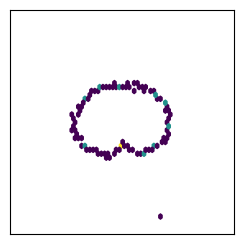

----------------------------------------

--- Displaying: 00023.png ---
Classification Result: without outlier
Image:


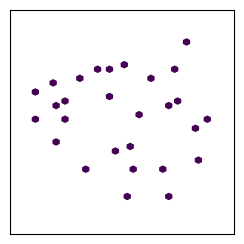

----------------------------------------

--- Displaying: 00003.png ---
Classification Result: without outlier
Image:


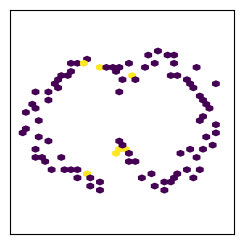

----------------------------------------

--- Displaying: 00018.png ---
Classification Result: without outlier
Image:


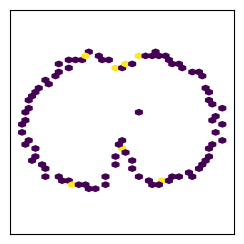

----------------------------------------

--- Displaying: 00016.png ---
Classification Result: without outlier
Image:


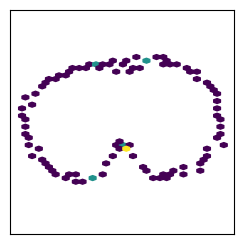

----------------------------------------

--- Displaying: 00017.png ---
Classification Result: Error - API Error (ResourceExhausted)
Image:


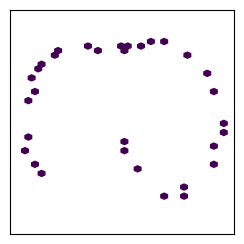

----------------------------------------

--- Displaying: 00007.png ---
Classification Result: with outlier
Image:


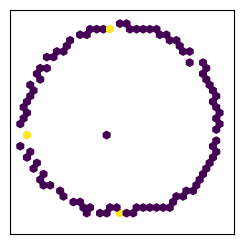

----------------------------------------

--- Displaying: 00029.png ---
Classification Result: with outlier
Image:


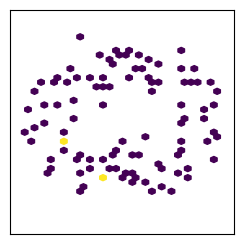

----------------------------------------

--- Displaying: 00013.png ---
Classification Result: without outlier
Image:


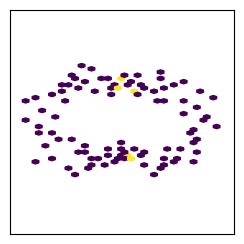

----------------------------------------

--- Displaying: 00021.png ---
Classification Result: with outlier
Image:


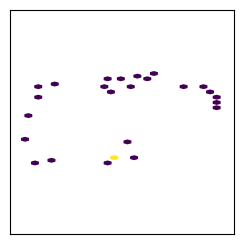

----------------------------------------

--- Finished displaying all images from the results file. ---


In [19]:
# --- 1. Imports (Ensure they are loaded) ---
import os
import pandas as pd
from IPython.display import display, Image, Markdown
import traceback

# --- 2. MODIFIED Function Definition ---
# Now accepts the DataFrame directly instead of the CSV path

def show_image_and_classification_from_df(
    filename_to_show: str,
    image_directory: str,
    results_df: pd.DataFrame, # Accepts the DataFrame
    image_width: int = 400
    ):
    """
    Displays an image and prints its classification result read from a DataFrame.

    Args:
        filename_to_show: The name of the image file to display.
        image_directory: The path to the directory containing the image files.
        results_df: The pandas DataFrame containing 'filename' and 'classification' columns.
        image_width: The desired display width for the image in pixels.
    """
    # --- Find Classification in the DataFrame ---
    if results_df is None or results_df.empty:
        print("Error: Results DataFrame is missing or empty.")
        return

    file_result = results_df[results_df['filename'] == filename_to_show]

    if file_result.empty:
        print(f"--- Skipping: Filename '{filename_to_show}' not found in the results DataFrame. ---")
        return
    else:
        classification = file_result['classification'].iloc[0]

    # --- Construct Image Path and Check Existence ---
    full_image_path = os.path.join(image_directory, filename_to_show)

    if not os.path.isfile(full_image_path):
        print(f"--- Skipping: Image file not found at '{full_image_path}' for filename '{filename_to_show}'. ---")
        return

    # --- Display Image and Print Result ---
    print(f"\n--- Displaying: {filename_to_show} ---")
    print(f"Classification Result: {classification}")

    try:
        print("Image:")
        display(Image(filename=full_image_path, width=image_width))
    except Exception as e:
        print(f"\nError displaying image '{full_image_path}': {e}")

    print("-" * 40) # Separator


# --- 3. Execution Block to Show ALL Images from CSV ---

# **IMPORTANT:** Adjust these paths based on your setup
images_directory = '/kaggle/input/test-images' # ADJUST THIS PATH
results_file = '/kaggle/working/image_outlier_results.csv' # Path where results were saved

print(f"--- Loading results from: {results_file} ---")
print(f"--- Image source directory: {images_directory} ---")

# --- Load the results dataframe ONCE ---
try:
    df_results = pd.read_csv(results_file)
    # Basic validation
    if 'filename' not in df_results.columns or 'classification' not in df_results.columns:
        raise ValueError("CSV file must contain 'filename' and 'classification' columns.")

except FileNotFoundError:
    print(f"\nError: Results CSV file not found at '{results_file}'")
    print("Please ensure the previous step ran successfully and saved the file.")
    df_results = None # Set df to None to prevent loop execution
except ValueError as ve:
     print(f"\nError loading results: {ve}")
     df_results = None
except Exception as e:
    print(f"\nError reading CSV file '{results_file}': {e}")
    df_results = None

# --- Loop through the DataFrame and display each image ---
if df_results is not None and not df_results.empty:
    print(f"\nFound {len(df_results)} entries in the results file. Displaying all...")

    # Iterate through each row of the DataFrame
    for index, row in df_results.iterrows():
        current_filename = row['filename']
        # Call the modified function that takes the DataFrame
        show_image_and_classification_from_df(
            filename_to_show=current_filename,
            image_directory=images_directory,
            results_df=df_results, # Pass the already loaded DataFrame
            image_width=350 # Adjust width as needed
        )
        # Optional: Add a small pause if output becomes too overwhelming
        # time.sleep(0.5)

    print("\n--- Finished displaying all images from the results file. ---")

elif df_results is not None and df_results.empty:
     print("\nThe results CSV file was loaded but it is empty. No images to display.")
else:
     print("\nCould not load results. Cannot display images.")